In [3]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [4]:
import pandas as pd

df = pd.read_csv('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/mnist_data/mnist_train.csv',header = None)


In [5]:
import matplotlib.pyplot as plt

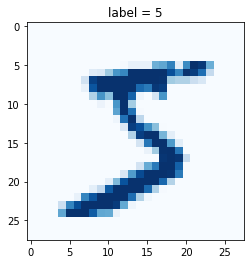

In [6]:
# get data from dataframe
row = 0
data = df.iloc[row]

# label is the first value
label = data[0]

# image data is the remaining 784 values
img = data[1:].values.reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation = 'none', cmap = 'Blues')
plt.show()

In [7]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    # 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,10),
        nn.LeakyReLU(0.02)
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # 변수 초기화
    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

  # 기울기 초기화, 역전파 실행, 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter+=1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0,1.0), figsize=(16,8), alpha = 0.1, marker = '.', grid = True, yticks = (0,0.25,0.5))
    pass

In [8]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pd.read_csv(csv_file, header=None)
    pass
  
  def __len__(self):
    return len(self.data_df)
  
  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
    
    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title("label = "+str(self.data_df.iloc[index,0]))
    plt.imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass

In [9]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/mnist_data/mnist_train.csv')

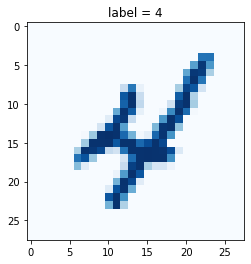

In [10]:
mnist_dataset.plot_image(9)

In [11]:
%%time

# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 2min 30s, sys: 1.47 s, total: 2min 32s
Wall time: 2min 33s


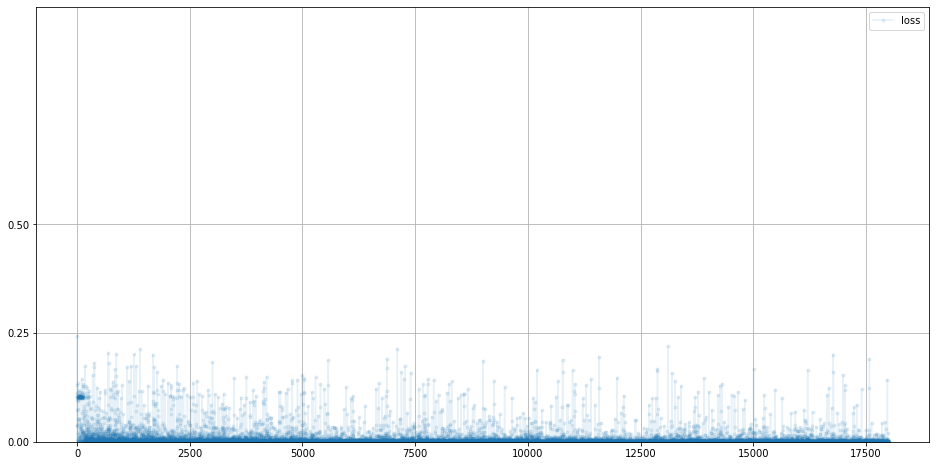

In [12]:
C.plot_progress()

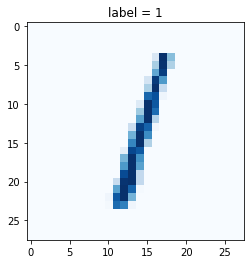

In [13]:
# MNIST 테스트 데이터 로드
mnist_test_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/mnist_data/mnist_test.csv')

# 레코드 설정
record =2

# 이미지와 정답 출력
mnist_test_dataset.plot_image(record)

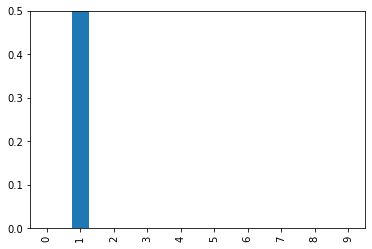

In [14]:
image_data = mnist_test_dataset[record][1]

# 훈련된 신경망으로부터 쿼리
output = C.forward(image_data)

# 텐서 출력
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,0.5))

In [15]:
# 훈련된 신경망을 테스트 데이터셋에 대해 테스트

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  if(answer.argmax()==label):
    score+=1
    pass
  items += 1

  pass


print(score, items, score/items)

9733 10000 0.9733
